
# Entrenamiento O3

In [1]:
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_tree

from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#import missingno as msn

pd.options.mode.chained_assignment = None 

from sklearn.externals import joblib
from xgboost.sklearn import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor 

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_regression

#### Hacemos una función para obtenner el -promedio- de los dos modelos

In [2]:
def predictor_mean(model0_1,modelo_2,X_set):  
    #aplicamos los predict
    forecast_q = model0_1.predict(X_set) 
    forecast = modelo_2.predict(X_set)
   #generamos una lista dummy: 
    forecast_mean = forecast 
    
    for i in range(len(X_set)):
        if  forecast[i] < 135:
            forecast_mean[i] = forecast[i]
        elif  forecast_q[i] > 160:
            forecast_mean[i] = forecast_q[i]
        if  130 < forecast_q[i] <155 and 130 < forecast[i] < 155:
            forecast_mean[i] = (0.3*forecast_q[i] + 0.7*forecast[i])
        if  140 < forecast_q[i] <160 and 140 < forecast[i] < 160:
            forecast_mean[i] = (forecast_q[i] + forecast[i])/2
    return forecast_mean

## Hacemos una función para graficar

In [ ]:
def ploter(y_test_0,X_test_0,pronosticados_0,model):
    
    plt.scatter(y_test_0, pronosticados_0,alpha=0.05,color="royalblue")
    score = round(model.score(X_test_0, y_test_0),3)
    rmse = round(np.sqrt(mean_squared_error(y_test_0, pronosticados_0)),3)
    plt.plot([30,130],[30,130],color="k",linestyle='--')
    
    plt.axhline(y=150, color='k', linestyle='--')
    plt.axvline(x=150, color='k', linestyle='--')
    plt.annotate('TP', (170,150), xytext = (175, 155 + 1), 
                  horizontalalignment='right')
    plt.annotate('FN', (170,150), xytext = (175, 135 + 1), 
                  horizontalalignment='right')
    plt.annotate('FP', (170,150), xytext = (125, 155 + 1), 
                  horizontalalignment='right')
    plt.annotate('FP', (170,150), xytext = (125, 135 + 1), 
                  horizontalalignment='right')
    plt.annotate("Score ="+str(score), (15,139), xytext = (15, 139 + 1), 
                  horizontalalignment='left')
    plt.annotate("RMSE ="+str(rmse), (15,119), xytext = (15, 119 + 1), 
                  horizontalalignment='left')
    
    
    plt.xlabel('Measured')
    plt.ylabel('Predicted')
    plt.title('Pronóstico con Persistencia Temporal')
    plt.show()

In [ ]:
def ploter_title(y_test_0,X_test_0,pronosticados_0,model,titulo,ejex,ejey,color_user,ruta="./savedpicO3.png",dpi_user=300):
    
    plt.scatter(y_test_0, pronosticados_0,alpha=0.05,color=color_user)
    score = round(model.score(X_test_0, y_test_0),3)
    rmse = round(np.sqrt(mean_squared_error(y_test_0, pronosticados_0)),3)
    plt.plot([30,130],[30,130],color="k",linestyle='--')
    
    plt.axhline(y=150, color='k', linestyle='--')
    plt.axvline(x=150, color='k', linestyle='--')
    plt.annotate('TP', (170,150), xytext = (175, 155 + 1), 
                  horizontalalignment='right')
    plt.annotate('FN', (170,150), xytext = (175, 135 + 1), 
                  horizontalalignment='right')
    plt.annotate('FP', (170,150), xytext = (125, 155 + 1), 
                  horizontalalignment='right')
    plt.annotate('FP', (170,150), xytext = (125, 135 + 1), 
                  horizontalalignment='right')
    plt.annotate("Score ="+str(score), (15,139), xytext = (15, 139 + 1), 
                  horizontalalignment='left')
    plt.annotate("RMSE ="+str(rmse), (15,119), xytext = (15, 119 + 1), 
                  horizontalalignment='left')
    
    
    plt.xlabel(ejex)
    plt.ylabel(ejey)
    plt.title(titulo)
    plt.savefig(ruta, dpi=dpi_user)
    plt.show()

## Cargamos los modelos ya entrenados:

In [5]:
conta = 'O3'

In [6]:
model = [0 for col in range(25)]
modelq = [0 for col in range(25)]

#### Cargamos los datos:

In [7]:
data_hour_merge = pd.read_csv("/DATA/paw/jupyterhub_notebook/daniel.bustillos/DanielBustillos/contaminación/pipeline-norberto/prediccion_sin_datos_de_pronostico/datos_modelos_O3.csv")

In [8]:
data_hour_merge[["fecha","O3_1.0_max","O3_max_frcst_1"]].tail(10)

,fecha,O3_1.0_max,O3_max_frcst_1
22219,2015-01-03 09:00:00,20.0,25.0
22220,2015-01-03 08:00:00,22.0,22.0
22221,2015-01-03 07:00:00,23.0,20.0
22222,2015-01-03 06:00:00,23.0,22.0
22223,2015-01-03 05:00:00,29.0,23.0
22224,2015-01-03 04:00:00,30.0,23.0
22225,2015-01-03 03:00:00,29.0,29.0
22226,2015-01-03 02:00:00,26.0,30.0
22227,2015-01-03 01:00:00,20.0,29.0
22228,2015-01-03 00:00:00,30.0,26.0


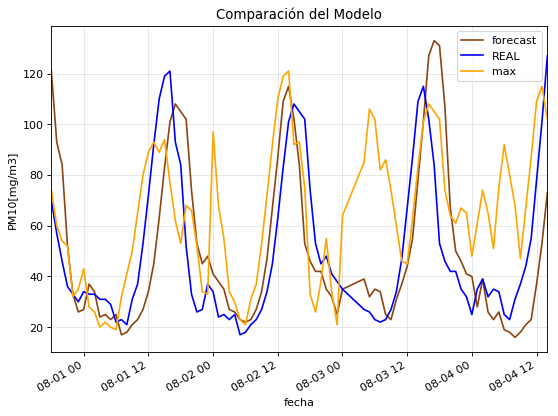

In [9]:
data_hour_merge['fecha'] =  pd.to_datetime(data_hour_merge['fecha'], format='%Y-%m-%d %H:%M')
fig = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
ax = fig.gca()

# df_export.(50).plot(x="fecha", y=[ "O3_y"],ax=ax,label=["O3 Medido"],color="dodgerblue")
# df_export.(60).head(100).plot(x="fecha", y=["O3_y_frcst_6"],ax=ax,label=["Pronóstico O3 a 12 horas"],color='darkblue',dashes=[6, 2])

data_hour_merge.head(90).plot(x="fecha", y=["O3_max_frcst_22"],ax=ax,label=["forecast"],color="saddlebrown")
data_hour_merge.head(90).plot(x="fecha", y=["O3_max"],ax=ax,label=["REAL"],color="blue")
data_hour_merge.head(90).plot(x="fecha", y=['O3_22.0_max'],ax=ax,label=["max"],color="orange")

#data_hour_merge.head(60).plot(x="fecha", y=["O3_pron_a_12hrs"],ax=ax,label=["Pronóstico PM10 a 12 horas"],color='maroon',dashes=[6, 2])

plt.ylabel("PM10[mg/m3]")
plt.title("Comparación del Modelo")


# And a corresponding grid
ax.grid(which='both')

# Or if you want different settings for the grids:
ax.grid(which='minor', alpha=0.01)
ax.grid(which='major', alpha=0.3)

plt.legend()
plt.show()

In [10]:
data_hour_merge.reset_index(inplace=True,drop=True)

In [11]:
data_hour_merge[data_hour_merge.fecha>"	2013-01-03 00:00:00"]

,TMP_24.0_mean,O3_3.0_max,RH_24.0_mean,O3_44.0_max,hora_35.0_mean,hora_9.0_mean,O3_2.0_max,O3_1.0_mean,hora_10.0_max,TMP_1.0_mean,...,O3_max_frcst_14,O3_max_frcst_15,O3_max_frcst_16,O3_max_frcst_17,O3_max_frcst_18,O3_max_frcst_19,O3_max_frcst_20,O3_max_frcst_21,O3_max_frcst_22,O3_max_frcst_23
0,22.170000,55.0,47.428571,108.0,3.419355,4.806452,78.0,73.677419,4.0,21.650000,...,19.0,18.0,16.0,18.0,21.0,23.0,37.0,53.0,73.0,101.0
1,21.731579,44.0,48.500000,101.0,20.533333,3.933333,55.0,57.900000,3.0,20.378947,...,26.0,19.0,18.0,16.0,18.0,21.0,23.0,37.0,53.0,73.0
2,21.022222,37.0,51.789474,83.0,19.517241,2.965517,44.0,39.931034,2.0,19.044444,...,23.0,26.0,19.0,18.0,16.0,18.0,21.0,23.0,37.0,53.0
3,19.822222,31.0,57.736842,63.0,18.517241,1.965517,37.0,26.724138,1.0,17.444444,...,26.0,23.0,26.0,19.0,18.0,16.0,18.0,21.0,23.0,37.0
4,18.647368,23.0,62.500000,45.0,17.600000,0.966667,31.0,17.600000,23.0,16.021053,...,39.0,26.0,23.0,26.0,19.0,18.0,16.0,18.0,21.0,23.0
5,17.545000,25.0,68.000000,46.0,16.677419,0.741935,23.0,8.677419,23.0,14.960000,...,28.0,39.0,26.0,23.0,26.0,19.0,18.0,16.0,18.0,21.0
6,16.340000,34.0,72.285714,60.0,15.677419,22.967742,25.0,4.064516,22.0,14.195000,...,40.0,28.0,39.0,26.0,23.0,26.0,19.0,18.0,16.0,18.0
7,15.610000,35.0,74.809524,74.0,14.677419,21.967742,34.0,7.032258,21.0,14.190000,...,41.0,40.0,28.0,39.0,26.0,23.0,26.0,19.0,18.0,16.0
8,15.840000,32.0,74.952381,86.0,13.677419,20.967742,35.0,9.000000,20.0,14.515000,...,46.0,41.0,40.0,28.0,39.0,26.0,23.0,26.0,19.0,18.0
9,16.285000,39.0,74.380952,82.0,13.419355,19.967742,32.0,14.225806,19.0,14.875000,...,50.0,46.0,41.0,40.0,28.0,39.0,26.0,23.0,26.0,19.0


In [12]:
data_hour_merge.drop("fecha",axis=1,inplace=True)

Definimos la lista de los targets:

In [13]:
target = "O3_max_frcst_"

lista = []
for i in range(1,25):
    lista.append(str(target+str(i)))

In [14]:
lista = []
for i in range(1,25):
    lista.append(str(target+str(i)))

In [15]:
conta = 'O3'

In [16]:
data_hour_merge.shape

(22229, 168)

# Empezamos con el entrenamiento:

#### HORA 1 

#### Definimos los conjuntos Train and Test<a class="anchor" id="5-bullet"></a>

In [17]:
hora = 1

dataset = data_hour_merge.copy()
#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)

X = dataset.loc[:, dataset.columns != str(target+str(hora))]
y = dataset[str(target+str(hora))]

X.drop(lista[hora:],axis=1,inplace=True)
if hora != 1:
    X.drop(lista[:hora-1],axis=1,inplace=True)

#Definimos los conjuntos de prueba:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [18]:
X_train.shape

(15560, 144)

In [19]:
X_train.columns.tolist()

['TMP_24.0_mean',
 'O3_3.0_max',
 'RH_24.0_mean',
 'O3_44.0_max',
 'hora_35.0_mean',
 'hora_9.0_mean',
 'O3_2.0_max',
 'O3_1.0_mean',
 'hora_10.0_max',
 'TMP_1.0_mean',
 'TMP_47.0_max',
 'TMP_21.0_max',
 'O3_0.0_min',
 'hora_19.0_min',
 'TMP_23.0_mean',
 'RH_25.0_mean',
 'RH_47.0_max',
 'RH_22.0_max',
 'RH_45.0_mean',
 'TMP_min',
 'NO_7.0_max',
 'NO_8.0_max',
 'TMP_21.0_mean',
 'TMP_46.0_mean',
 'hora_34.0_min',
 'RH_21.0_max',
 'RH_2.0_min',
 'O3_1.0_min',
 'NO_8.0_mean',
 'hora_21.0_mean',
 'O3_mean',
 'hora_11.0_mean',
 'RH_2.0_max',
 'RH_48.0_mean',
 'O3_21.0_min',
 'O3_2.0_min',
 'O3_0.0_mean',
 'O3_45.0_min',
 'RH_22.0_min',
 'TMP_46.0_min',
 'TMP_22.0_min',
 'RH_1.0_max',
 'RH_24.0_min',
 'O3_max',
 'O3_21.0_mean',
 'RH_23.0_max',
 'hora_19.0_mean',
 'O3_23.0_mean',
 'O3_24.0_max',
 'NOX_7.0_mean',
 'RH_23.0_mean',
 'O3_3.0_mean',
 'TMP_48.0_max',
 'TMP_45.0_max',
 'TMP_48.0_mean',
 'O3_46.0_max',
 'O3_21.0_max',
 'O3_48.0_max',
 'TMP_25.0_mean',
 'RH_2.0_mean',
 'hora_20.0_mean

## Modelo

In [20]:
from xgboost.sklearn import XGBRegressor

In [21]:
model[hora-1] = XGBRegressor(learning_rate=0.01,n_estimators=1500,random_state=123,max_depth=10)

In [22]:
model[0].fit(X_train, y_train)
#Predict 

/home/paw/software/python/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:33:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.01, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=1500,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=123,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [23]:
pronos_1 = model[0].predict(X_test)

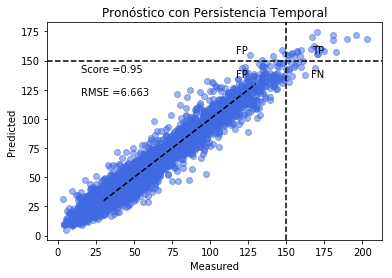

In [24]:
ploter(y_test,X_test,pronos_1,model[0])

In [26]:
# now you can save it to a file
joblib.dump(model[hora-1], './modelos/'+ conta +'/'+ conta +'_'+ str(hora)+ 'hora.pkl')

['./modelos/O3/O3_1hora.pkl']

## Gradienst Descent:

# HORA 2

### Definimos los conjuntos Train and Test<a class="anchor" id="5-bullet"></a>

In [21]:
hora = 2

In [22]:
dataset = data_hour_merge.copy()
#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)

In [23]:
X = dataset.loc[:, dataset.columns != str(target+str(hora))]
y = dataset[str(target+str(hora))]

In [24]:
X.drop(lista[hora:],axis=1,inplace=True)
if hora != 1:
    X.drop(lista[:hora-1],axis=1,inplace=True)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

## Modelos

### Leemos el pasado

# Quantile 95

## modelo normal

In [ ]:
model[hora-1] = XGBRegressor(learning_rate=0.01,n_estimators=2500,random_state=123,max_depth=10)

In [ ]:
model[1].fit(X_train, y_train)

/home/paw/software/python/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[14:48:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
pronos_2_q = model[1].predict(X_test)

In [ ]:
ploter(y_test,X_test,pronos_2_q,model[1])

In [ ]:
# now you can save it to a file
joblib.dump(model[hora-1], './modelos/'+conta+'/'+conta+'_'+str(hora)+'hora.pkl')

# HORA 3

### Definimos los conjuntos Train and Test<a class="anchor" id="5-bullet"></a>

In [ ]:
hora = 3

In [ ]:
dataset = data_hour_merge.copy()
#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)

In [ ]:
X = dataset.loc[:, dataset.columns != str(target+str(hora))]
y = dataset[str(target+str(hora))]

In [ ]:
X.drop(lista[hora:],axis=1,inplace=True)
if hora != 1:
    X.drop(lista[:hora-1],axis=1,inplace=True)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

## Modelos

### Leemos el pasado

# Quantile 95

## modelo normal

In [ ]:
model[hora-1] = XGBRegressor(learning_rate=0.05,n_estimaators=2500,n_jobs=124,random_state=123,max_depth=10, gamma=1.16)

In [ ]:
model[hora-1].fit(X_train, y_train)

In [ ]:
pronos_2_q = model[hora-1].predict(X_test)

In [ ]:
ploter(y_test,X_test,pronos_2_q,model[hora-1])

In [ ]:
# now you can save it to a file
joblib.dump(model[hora-1],'./modelos/'+conta+'/'+conta+'_'+str(hora)+'hora.pkl') 

# HORA 4

### Definimos los conjuntos Train and Test<a class="anchor" id="5-bullet"></a>

In [ ]:
hora = 4

In [ ]:
dataset = data_hour_merge.copy()
#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)

In [ ]:
X = dataset.loc[:, dataset.columns != str(target+str(hora))]
y = dataset[str(target+str(hora))]

In [ ]:
X.drop(lista[hora:],axis=1,inplace=True)
if hora != 1:
    X.drop(lista[:hora-1],axis=1,inplace=True)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

## Modelos

### Leemos el pasado

# Quantile 95

## modelo normal

In [ ]:
model[hora-1] = XGBRegressor(learning_rate=0.01,n_estimators=2500,n_jobs=100,random_state=123,max_depth=10)

In [ ]:
model[hora-1].fit(X_train, y_train)

In [ ]:
pronos_2_q = model[hora-1].predict(X_test)

In [ ]:
ploter(y_test,X_test,pronos_2_q,model[hora-1])

In [ ]:
# now you can save it to a file
joblib.dump(model[hora-1],'./modelos/'+conta+'/'+conta+'_'+str(hora)+'hora.pkl') 

# HORA 5

### Definimos los conjuntos Train and Test<a class="anchor" id="5-bullet"></a>

In [ ]:
hora = 5

In [ ]:
dataset = data_hour_merge.copy()
#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)

In [ ]:
X = dataset.loc[:, dataset.columns != str(target+str(hora))]
y = dataset[str(target+str(hora))]

In [ ]:
X.drop(lista[hora:],axis=1,inplace=True)
if hora != 1:
    X.drop(lista[:hora-1],axis=1,inplace=True)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

## Modelos

### Leemos el pasado

# Quantile 95

## modelo normal

In [ ]:
model[hora-1] = XGBRegressor(learning_rate=0.01,n_estimators=2500,n_jobs=100,random_state=123,max_depth=10)

In [ ]:
model[hora-1].fit(X_train, y_train)

In [ ]:
pronos_2_q = model[hora-1].predict(X_test)

In [ ]:
ploter(y_test,X_test,pronos_2_q,model[hora-1])

In [ ]:
ploter(y_test,X_test,pronos_2_q,model[hora-1])

In [ ]:
# now you can save it to a file
joblib.dump(model[hora-1],'./modelos/'+conta+'/'+conta+'_'+str(hora)+'hora.pkl') 

# HORA 6

### Definimos los conjuntos Train and Test<a class="anchor" id="5-bullet"></a>

In [ ]:
hora = 6

In [ ]:
dataset = data_hour_merge.copy()
#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)

In [ ]:
X = dataset.loc[:, dataset.columns != str(target+str(hora))]
y = dataset[str(target+str(hora))]

In [ ]:
X.drop(lista[hora:],axis=1,inplace=True)
if hora != 1:
    X.drop(lista[:hora-1],axis=1,inplace=True)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

## Modelos

### Leemos el pasado

# Quantile 95

## modelo normal

In [ ]:
model[hora-1] = XGBRegressor(learning_rate=0.01,n_estimators=2500,n_jobs=100,random_state=123,max_depth=10)

In [ ]:
model[hora-1].fit(X_train, y_train)

In [ ]:
pronos_2_q = model[hora-1].predict(X_test)

In [ ]:
ploter(y_test,X_test,pronos_2_q,model[hora-1])

In [ ]:
# now you can save it to a file
joblib.dump(model[hora-1],'./modelos/'+conta+'/'+conta+'_'+str(hora)+'hora.pkl') 

# HORA 7

### Definimos los conjuntos Train and Test<a class="anchor" id="5-bullet"></a>

In [ ]:
hora = 7

In [ ]:
dataset = data_hour_merge.copy()
#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)

In [ ]:
X = dataset.loc[:, dataset.columns != str(target+str(hora))]
y = dataset[str(target+str(hora))]

In [ ]:
X.drop(lista[hora:],axis=1,inplace=True)
if hora != 1:
    X.drop(lista[:hora-1],axis=1,inplace=True)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

## Modelos

### Leemos el pasado

# Quantile 95

## modelo normal

In [ ]:
model[hora-1] = XGBRegressor(learning_rate=0.01,n_estimators=2500,n_jobs=100,random_state=123,max_depth=10)

In [ ]:
model[hora-1].fit(X_train, y_train)

In [ ]:
pronos_2_q = model[hora-1].predict(X_test)

In [ ]:
ploter(y_test,X_test,pronos_2_q,model[hora-1])

In [ ]:
# now you can save it to a file
joblib.dump(model[hora-1],'./modelos/'+conta+'/'+conta+'_'+str(hora)+'hora.pkl') 

# HORA 8

### Definimos los conjuntos Train and Test<a class="anchor" id="5-bullet"></a>

In [ ]:
hora = 8

In [ ]:
dataset = data_hour_merge.copy()
#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)

In [ ]:
X = dataset.loc[:, dataset.columns != str(target+str(hora))]
y = dataset[str(target+str(hora))]

In [ ]:
X.drop(lista[hora:],axis=1,inplace=True)
if hora != 1:
    X.drop(lista[:hora-1],axis=1,inplace=True)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

## Modelos

### Leemos el pasado

# Quantile 95

## modelo normal

In [ ]:
model[hora-1] = XGBRegressor(learning_rate=0.01,n_estimators=2500,n_jobs=100,random_state=123,max_depth=10)

In [ ]:
model[hora-1].fit(X_train, y_train)

In [ ]:
pronos_2_q = model[hora-1].predict(X_test)

In [ ]:
ploter(y_test,X_test,pronos_2_q,model[hora-1])

In [ ]:
# now you can save it to a file
joblib.dump(model[hora-1],'./modelos/'+conta+'/'+conta+'_'+str(hora)+'hora.pkl') 

# HORA 9

### Definimos los conjuntos Train and Test<a class="anchor" id="5-bullet"></a>

In [ ]:
hora = 9

In [ ]:
dataset = data_hour_merge.copy()
#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)

In [ ]:
X = dataset.loc[:, dataset.columns != str(target+str(hora))]
y = dataset[str(target+str(hora))]

In [ ]:
X.drop(lista[hora:],axis=1,inplace=True)
if hora != 1:
    X.drop(lista[:hora-1],axis=1,inplace=True)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

## Modelos

### Leemos el pasado

# Quantile 95

## modelo normal

In [ ]:
model[hora-1] = XGBRegressor(learning_rate=0.01,n_estimators=2500,n_jobs=100,random_state=123,max_depth=10)

In [ ]:
model[hora-1].fit(X_train, y_train)

In [ ]:
pronos_2_q = model[hora-1].predict(X_test)

In [ ]:
ploter(y_test,X_test,pronos_2_q,model[hora-1])

In [ ]:
# now you can save it to a file
joblib.dump(model[hora-1],'./modelos/'+conta+'/'+conta+'_'+str(hora)+'hora.pkl') 

# HORA 10

### Definimos los conjuntos Train and Test<a class="anchor" id="5-bullet"></a>

In [ ]:
hora = 10

In [ ]:
dataset = data_hour_merge.copy()
#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)

In [ ]:
X = dataset.loc[:, dataset.columns != str(target+str(hora))]
y = dataset[str(target+str(hora))]

In [ ]:
X.drop(lista[hora:],axis=1,inplace=True)
if hora != 1:
    X.drop(lista[:hora-1],axis=1,inplace=True)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

## Modelos

### Leemos el pasado

# Quantile 95

## modelo normal

In [ ]:
model[hora-1] = XGBRegressor(learning_rate=0.01,n_estimators=2500,n_jobs=100,random_state=123,max_depth=10)

In [ ]:
model[hora-1].fit(X_train, y_train)

In [ ]:
pronos_2_q = model[hora-1].predict(X_test)

In [ ]:
ploter(y_test,X_test,pronos_2_q,model[hora-1])

In [ ]:
# now you can save it to a file
joblib.dump(model[hora-1],'./modelos/'+conta+'/'+conta+'_'+str(hora)+'hora.pkl') 

# HORA 11

### Definimos los conjuntos Train and Test<a class="anchor" id="5-bullet"></a>

In [ ]:
hora = 11

In [ ]:
dataset = data_hour_merge.copy()
#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)

In [ ]:
X = dataset.loc[:, dataset.columns != str(target+str(hora))]
y = dataset[str(target+str(hora))]

In [ ]:
X.drop(lista[hora:],axis=1,inplace=True)
if hora != 1:
    X.drop(lista[:hora-1],axis=1,inplace=True)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

## Modelos

### Leemos el pasado

# Quantile 95

## modelo normal

In [ ]:
model[hora-1] = XGBRegressor(learning_rate=0.01,n_estimators=2500,n_jobs=100,random_state=123,max_depth=10)

In [ ]:
model[hora-1].fit(X_train, y_train)

In [ ]:
pronos_2_q = model[hora-1].predict(X_test)

In [ ]:
ploter(y_test,X_test,pronos_2_q,model[hora-1])

In [ ]:
# now you can save it to a file
joblib.dump(model[hora-1],'./modelos/'+conta+'/'+conta+'_'+str(hora)+'hora.pkl') 

# HORA 12

### Definimos los conjuntos Train and Test<a class="anchor" id="5-bullet"></a>

In [50]:
hora = 12

In [51]:
dataset = data_hour_merge.copy()
#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)

In [52]:
X = dataset.loc[:, dataset.columns != str(target+str(hora))]
y = dataset[str(target+str(hora))]

In [53]:
X.drop(lista[hora:],axis=1,inplace=True)
if hora != 1:
    X.drop(lista[:hora-1],axis=1,inplace=True)

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=123)

## Modelos

### Leemos el pasado

# Quantile 95

## modelo normal

In [55]:
model[hora-1] = XGBRegressor(learning_rate=0.01,n_estimators=1500,n_jobs=100,random_state=123,max_depth=10)

In [56]:
model[hora-1].fit(X_train, y_train)

/home/paw/software/python/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:50:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.01, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=1500,
       n_jobs=100, nthread=None, objective='reg:linear', random_state=123,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [57]:
pronos_2_q = model[hora-1].predict(X_test)

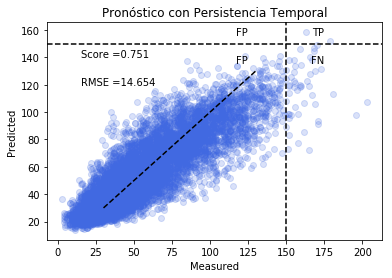

In [58]:
ploter(y_test,X_test,pronos_2_q,model[hora-1])

In [59]:
# now you can save it to a file
joblib.dump(model[hora-1],'./modelos/'+conta+'/'+conta+'_'+str(hora)+'hora.pkl') 

['./modelos/O3/O3_12hora.pkl']

# HORA 13

### Definimos los conjuntos Train and Test<a class="anchor" id="5-bullet"></a>

In [143]:
hora = 13

In [144]:
dataset = data_hour_merge.copy()
#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)

In [145]:
X = dataset.loc[:, dataset.columns != str(target+str(hora))]
y = dataset[str(target+str(hora))]

In [146]:
X.drop(lista[hora:],axis=1,inplace=True)
if hora != 1:
    X.drop(lista[:hora-1],axis=1,inplace=True)

In [147]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

## Modelos

### Leemos el pasado

# Quantile 95

## modelo normal

In [148]:
model[hora-1] = XGBRegressor(learning_rate=0.01,n_estimators=2500,n_jobs=100,random_state=123,max_depth=10)

In [149]:
model[hora-1].fit(X_train, y_train)

/home/paw/software/python/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[13:40:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.01, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=2500,
       n_jobs=100, nthread=None, objective='reg:linear', random_state=123,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [150]:
pronos_2_q = model[hora-1].predict(X_test)

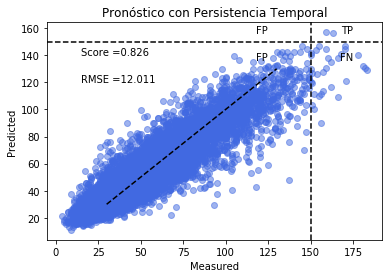

In [151]:
ploter(y_test,X_test,pronos_2_q,model[hora-1])

In [152]:
# now you can save it to a file
joblib.dump(model[hora-1],'./modelos/'+conta+'/'+conta+'_'+str(hora)+'hora.pkl') 

['./modelos/O3/O3_13hora.pkl']

# HORA 14

### Definimos los conjuntos Train and Test<a class="anchor" id="5-bullet"></a>

In [153]:
hora = 14

In [154]:
dataset = data_hour_merge.copy()
#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)

In [155]:
X = dataset.loc[:, dataset.columns != str(target+str(hora))]
y = dataset[str(target+str(hora))]

In [156]:
X.drop(lista[hora:],axis=1,inplace=True)
if hora != 1:
    X.drop(lista[:hora-1],axis=1,inplace=True)

In [157]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

## Modelos

### Leemos el pasado

# Quantile 95

## modelo normal

In [158]:
model[hora-1] = XGBRegressor(learning_rate=0.01,n_estimators=2500,n_jobs=100,random_state=123,max_depth=10)

In [159]:
model[hora-1].fit(X_train, y_train)

/home/paw/software/python/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[13:48:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.01, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=2500,
       n_jobs=100, nthread=None, objective='reg:linear', random_state=123,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [160]:
pronos_2_q = model[hora-1].predict(X_test)

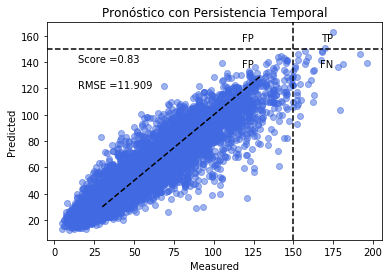

In [161]:
ploter(y_test,X_test,pronos_2_q,model[hora-1])

In [162]:
# now you can save it to a file
joblib.dump(model[hora-1], './modelos/'+conta+'/'+conta+'_'+str(hora)+'hora.pkl')

['./modelos/O3/O3_14hora.pkl']

# HORA 15

### Definimos los conjuntos Train and Test<a class="anchor" id="5-bullet"></a>

In [163]:
hora = 15

In [164]:
dataset = data_hour_merge.copy()
#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)

In [165]:
X = dataset.loc[:, dataset.columns != str(target+str(hora))]
y = dataset[str(target+str(hora))]

In [166]:
X.drop(lista[hora:],axis=1,inplace=True)
if hora != 1:
    X.drop(lista[:hora-1],axis=1,inplace=True)

In [167]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

## Modelos

### Leemos el pasado

# Quantile 95

## modelo normal

In [168]:
model[hora-1] = XGBRegressor(learning_rate=0.01,n_estimators=2500,n_jobs=100,random_state=123,max_depth=10)

In [169]:
model[hora-1].fit(X_train, y_train)

/home/paw/software/python/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[13:56:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.01, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=2500,
       n_jobs=100, nthread=None, objective='reg:linear', random_state=123,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [170]:
pronos_2_q = model[hora-1].predict(X_test)

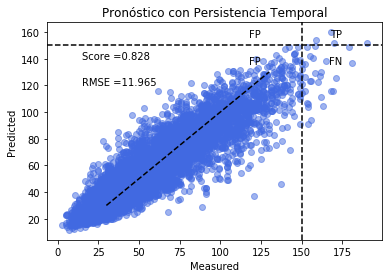

In [171]:
ploter(y_test,X_test,pronos_2_q,model[hora-1])

In [172]:
# now you can save it to a file
joblib.dump(model[hora-1],'./modelos/'+conta+'/'+conta+'_'+str(hora)+'hora.pkl') 

['./modelos/O3/O3_15hora.pkl']

# HORA 16

### Definimos los conjuntos Train and Test<a class="anchor" id="5-bullet"></a>

In [173]:
hora = 16

In [174]:
dataset = data_hour_merge.copy()
#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)

In [175]:
X = dataset.loc[:, dataset.columns != str(target+str(hora))]
y = dataset[str(target+str(hora))]

In [176]:
X.drop(lista[hora:],axis=1,inplace=True)
if hora != 1:
    X.drop(lista[:hora-1],axis=1,inplace=True)

In [177]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

## Modelos

### Leemos el pasado

# Quantile 95

## modelo normal

In [178]:
model[hora-1] = XGBRegressor(learning_rate=0.01,n_estimators=2500,n_jobs=100,random_state=123,max_depth=10)

In [179]:
model[hora-1].fit(X_train, y_train)

/home/paw/software/python/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[14:03:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.01, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=2500,
       n_jobs=100, nthread=None, objective='reg:linear', random_state=123,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [180]:
pronos_2_q = model[hora-1].predict(X_test)

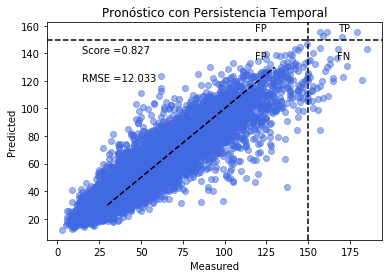

In [181]:
ploter(y_test,X_test,pronos_2_q,model[hora-1])

In [182]:
# now you can save it to a file
joblib.dump(model[hora-1],'./modelos/'+conta+'/'+conta+'_'+str(hora)+'hora.pkl') 

['./modelos/O3/O3_16hora.pkl']

# HORA 17

### Definimos los conjuntos Train and Test<a class="anchor" id="5-bullet"></a>

In [183]:
hora = 17

In [184]:
dataset = data_hour_merge.copy()
#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)

In [185]:
X = dataset.loc[:, dataset.columns != str(target+str(hora))]
y = dataset[str(target+str(hora))]

In [186]:
X.drop(lista[hora:],axis=1,inplace=True)
if hora != 1:
    X.drop(lista[:hora-1],axis=1,inplace=True)

In [187]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

## Modelos

### Leemos el pasado

# Quantile 95

## modelo normal

In [188]:
model[hora-1] = XGBRegressor(learning_rate=0.01,n_estimators=2500,n_jobs=100,random_state=123,max_depth=10)

In [189]:
model[hora-1].fit(X_train, y_train)

/home/paw/software/python/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[14:11:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.01, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=2500,
       n_jobs=100, nthread=None, objective='reg:linear', random_state=123,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [190]:
pronos_2_q = model[hora-1].predict(X_test)

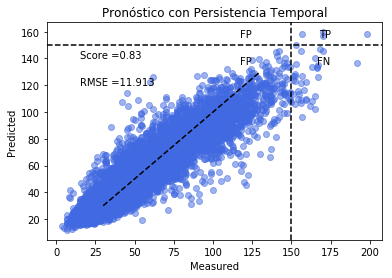

In [191]:
ploter(y_test,X_test,pronos_2_q,model[hora-1])

In [192]:
# now you can save it to a file
joblib.dump(model[hora-1],'./modelos/'+conta+'/'+conta+'_'+str(hora)+'hora.pkl') 

['./modelos/O3/O3_17hora.pkl']

# HORA 18

### Definimos los conjuntos Train and Test<a class="anchor" id="5-bullet"></a>

In [193]:
hora = 18

In [194]:
dataset = data_hour_merge.copy()
#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)

In [195]:
X = dataset.loc[:, dataset.columns != str(target+str(hora))]
y = dataset[str(target+str(hora))]

In [196]:
X.drop(lista[hora:],axis=1,inplace=True)
if hora != 1:
    X.drop(lista[:hora-1],axis=1,inplace=True)

In [197]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

## Modelos

### Leemos el pasado

# Quantile 95

## modelo normal

In [198]:
model[hora-1] = XGBRegressor(learning_rate=0.01,n_estimators=2500,n_jobs=100,random_state=123,max_depth=10)

In [199]:
model[hora-1].fit(X_train, y_train)

/home/paw/software/python/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[14:18:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.01, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=2500,
       n_jobs=100, nthread=None, objective='reg:linear', random_state=123,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [200]:
pronos_2_q = model[hora-1].predict(X_test)

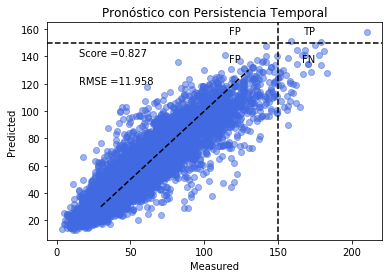

In [201]:
ploter(y_test,X_test,pronos_2_q,model[hora-1])

In [202]:
# now you can save it to a file
joblib.dump(model[hora-1],'./modelos/'+conta+'/'+ conta+'_'+ str(hora) + 'hora.pkl') 

['./modelos/O3/O3_18hora.pkl']

# HORA 19

### Definimos los conjuntos Train and Test<a class="anchor" id="5-bullet"></a>

In [203]:
 hora = 19

In [204]:
dataset = data_hour_merge.copy()
#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)

In [205]:
X = dataset.loc[:, dataset.columns != str(target+str(hora))]
y = dataset[str(target+str(hora))]

In [206]:
X.drop(lista[hora:],axis=1,inplace=True)
if hora != 1:
    X.drop(lista[:hora-1],axis=1,inplace=True)

In [207]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

## Modelos

### Leemos el pasado

# Quantile 95

## modelo normal

In [208]:
model[hora-1] = XGBRegressor(learning_rate=0.01,n_estimators=2500,n_jobs=100,random_state=123,max_depth=10)

In [209]:
model[hora-1].fit(X_train, y_train)

/home/paw/software/python/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[14:26:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.01, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=2500,
       n_jobs=100, nthread=None, objective='reg:linear', random_state=123,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [210]:
pronos_2_q = model[hora-1].predict(X_test)

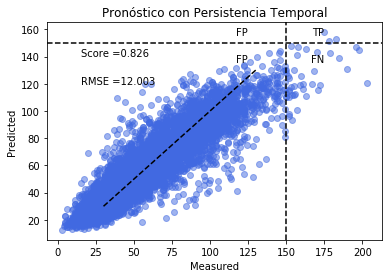

In [211]:
ploter(y_test,X_test,pronos_2_q,model[hora-1])

In [212]:
# now you can save it to a file
joblib.dump(model[hora-1],'./modelos/'+conta+'/'+conta+'_'+str(hora)+'hora.pkl') 

['./modelos/O3/O3_19hora.pkl']

# HORA 20

### Definimos los conjuntos Train and Test<a class="anchor" id="5-bullet"></a>

In [213]:
hora = 20

In [214]:
dataset = data_hour_merge.copy()
#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)

In [215]:
X = dataset.loc[:, dataset.columns != str(target+str(hora))]
y = dataset[str(target+str(hora))]

In [216]:
X.drop(lista[hora:],axis=1,inplace=True)
if hora != 1:
    X.drop(lista[:hora-1],axis=1,inplace=True)

In [217]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

## Modelos

### Leemos el pasado

# Quantile 95

## modelo normal

In [218]:
model[hora-1] = XGBRegressor(learning_rate=0.01,n_estimators=2500,n_jobs=100,random_state=123,max_depth=10)

In [219]:
model[hora-1].fit(X_train, y_train)

/home/paw/software/python/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[14:34:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.01, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=2500,
       n_jobs=100, nthread=None, objective='reg:linear', random_state=123,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [220]:
pronos_2_q = model[hora-1].predict(X_test)

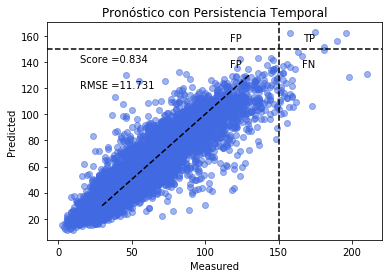

In [221]:
ploter(y_test,X_test,pronos_2_q,model[hora-1])

In [222]:
# now you can save it to a file
joblib.dump(model[hora-1],'./modelos/'+conta+'/'+conta+'_'+str(hora)+'hora.pkl') 

['./modelos/O3/O3_20hora.pkl']

# HORA 21

### Definimos los conjuntos Train and Test<a class="anchor" id="5-bullet"></a>

In [223]:
hora = 21

In [224]:
dataset = data_hour_merge.copy()
#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)

In [225]:
X = dataset.loc[:, dataset.columns != str(target+str(hora))]
y = dataset[str(target+str(hora))]

In [226]:
X.drop(lista[hora:],axis=1,inplace=True)
if hora != 1:
    X.drop(lista[:hora-1],axis=1,inplace=True)

In [227]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

## Modelos

### Leemos el pasado

# Quantile 95

## modelo normal

In [228]:
model[hora-1] = XGBRegressor(learning_rate=0.01,n_estimators=2500,n_jobs=100,random_state=123,max_depth=10)

In [229]:
model[hora-1].fit(X_train, y_train)

/home/paw/software/python/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[14:41:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.01, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=2500,
       n_jobs=100, nthread=None, objective='reg:linear', random_state=123,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [230]:
pronos_2_q = model[hora-1].predict(X_test)

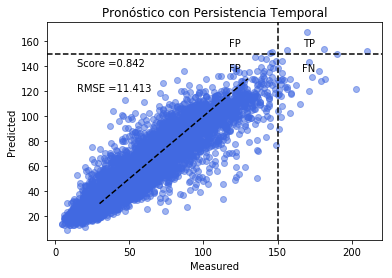

In [231]:
ploter(y_test,X_test,pronos_2_q,model[hora-1])

In [232]:
# now you can save it to a file
joblib.dump(model[hora-1], './modelos/'+conta+'/'+conta+'_'+str(hora)+'hora.pkl')

['./modelos/O3/O3_21hora.pkl']

## Hora 22

### Definimos los conjuntos Train and Test<a class="anchor" id="5-bullet"></a>

In [233]:
hora = 22

In [234]:
dataset = data_hour_merge.copy()
#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)

In [235]:
X = dataset.loc[:, dataset.columns != str(target+str(hora))]
y = dataset[str(target+str(hora))]

In [236]:
X.drop(lista[hora:],axis=1,inplace=True)
if hora != 1:
    X.drop(lista[:hora-1],axis=1,inplace=True)

In [237]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

## Modelos

### Leemos el pasado

# Quantile 95

## modelo normal

In [238]:
model[hora-1] = XGBRegressor(learning_rate=0.01,n_estimators=2500,n_jobs=100,random_state=123,max_depth=10)

In [239]:
model[hora-1].fit(X_train, y_train)

/home/paw/software/python/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[14:50:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.01, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=2500,
       n_jobs=100, nthread=None, objective='reg:linear', random_state=123,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [240]:
pronos_2_q = model[hora-1].predict(X_test)

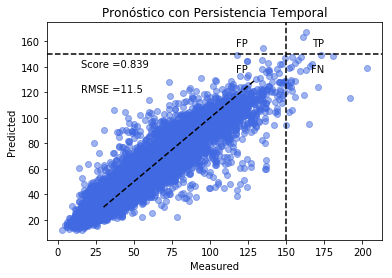

In [241]:
ploter(y_test,X_test,pronos_2_q,model[hora-1])

In [242]:
# now you can save it to a file
joblib.dump(model[hora-1],'./modelos/'+conta+'/'+conta+'_'+str(hora)+'hora.pkl') 

['./modelos/O3/O3_22hora.pkl']

# HORA 23

### Definimos los conjuntos Train and Test<a class="anchor" id="5-bullet"></a>

In [243]:
hora = 23

In [244]:
dataset = data_hour_merge.copy()
#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)

In [245]:
X = dataset.loc[:, dataset.columns != str(target+str(hora))]
y = dataset[str(target+str(hora))]

In [246]:
X.drop(lista[hora:],axis=1,inplace=True)
if hora != 1:
    X.drop(lista[:hora-1],axis=1,inplace=True)

In [247]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

## Modelos

### Leemos el pasado

# Quantile 95

## modelo normal

In [248]:
model[hora-1] = XGBRegressor(learning_rate=0.01,n_estimators=2500,n_jobs=100,random_state=123,max_depth=10)

In [249]:
model[hora-1].fit(X_train, y_train)

/home/paw/software/python/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[14:58:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.01, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=2500,
       n_jobs=100, nthread=None, objective='reg:linear', random_state=123,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [250]:
pronos_2_q = model[hora-1].predict(X_test)

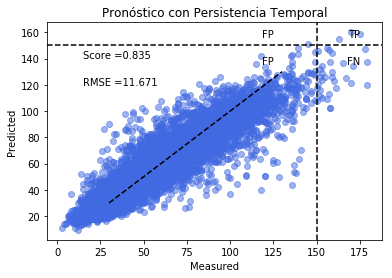

In [251]:
ploter(y_test,X_test,pronos_2_q,model[hora-1])

In [252]:
# now you can save it to a file
joblib.dump(model[hora-1],'./modelos/'+conta+'/'+conta+'_'+str(hora)+'hora.pkl') 

['./modelos/O3/O3_23hora.pkl']

# HORA 24

### Definimos los conjuntos Train and Test<a class="anchor" id="5-bullet"></a>

In [27]:
hora = 24

In [28]:
dataset = data_hour_merge.copy()
#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)

In [29]:
X = dataset.loc[:, dataset.columns != str(target+str(hora))]
y = dataset[str(target+str(hora))]

In [30]:
X.drop(lista[hora:],axis=1,inplace=True)
if hora != 1:
    X.drop(lista[:hora-1],axis=1,inplace=True)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

## Modelos

### Leemos el pasado

# Quantile 95

## modelo normal

In [34]:
model[hora-1] = XGBRegressor(learning_rate=0.01,n_estimators=1500,n_jobs=100,random_state=123,max_depth=10)

In [35]:
model[hora-1].fit(X_train, y_train)

[15:46:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.01, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=1500,
       n_jobs=100, nthread=None, objective='reg:linear', random_state=123,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [36]:
pronos_2_q = model[hora-1].predict(X_test)

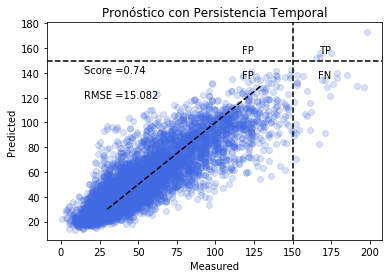

In [45]:
ploter(y_test,X_test,pronos_2_q,model[hora-1]) #XGBRegressor(learning_rate=0.1,n_estimators=2500,n_jobs=100,random_state=123,max_depth=3)

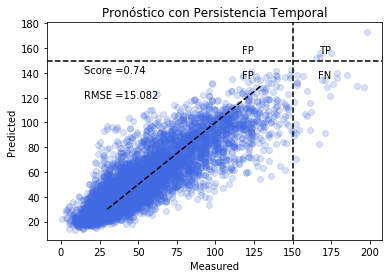

In [46]:
ploter(y_test,X_test,pronos_2_q,model[hora-1]) #XGBRegressor(learning_rate=0.1,n_estimators=2500,n_jobs=100,random_state=123,max_depth=3)

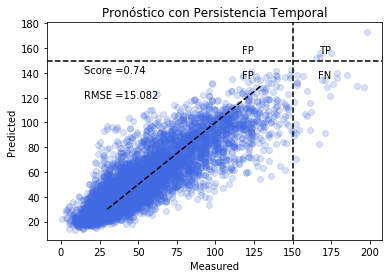

In [47]:
ploter(y_test,X_test,pronos_2_q,model[hora-1]) #XGBRegressor(learning_rate=0.1,n_estimators=2500,n_jobs=100,random_state=123,max_depth=5)

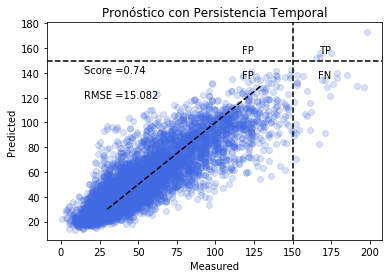

In [48]:
ploter(y_test,X_test,pronos_2_q,model[hora-1]) #XGBRegressor(learning_rate=0.1,n_estimators=2500,n_jobs=100,random_state=123,max_depth=10)

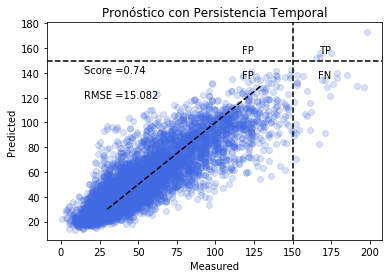

In [49]:
ploter(y_test,X_test,pronos_2_q,model[hora-1])#XGBRegressor(learning_rate=0.01,n_estimators=2500,n_jobs=100,random_state=123,max_depth=10)

In [42]:
# now you can save it to a file
joblib.dump(model[hora-1],'./modelos/'+conta+'/'+conta+'_'+str(hora)+'hora.pkl') 

['./modelos/O3/O3_24hora.pkl']

# HORA 24 Test

### Definimos los conjuntos Train and Test<a class="anchor" id="5-bullet"></a>

## Modelos

### Leemos el pasado

# Quantile 95

## modelo normal

### Prueba